# ***Classifying Toxic Comments with DistilBERT***

By Nakshatra Singh

This notebook will show you how to Fine Tune DistilBERT for MultiLabel Text Classification.

###**Using Google GPU for Training**

Google colab offers free GPUs and TPUs! Since we'll be training a large model it's best to take advantage of this (in this case we'll use GPU), otherwise training can take long time.

A GPU can be added by going to the menu and selecting:

`Edit -> Notebook Settings -> Hardware Accelerator -> (GPU)`

Then run the following cell to confirm that a GPU is detected.

In [1]:
import tensorflow as tf
# Get the device GPU name 
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
  print('Found GPU at : {}'.format(device_name)) 
else:
  raise SystemError('GPU not found!') 

Found GPU at : /device:GPU:0


In order for torch to use GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [2]:
import torch

# If there is a GPU available...
if torch.cuda.is_available():

  # Tell pytorch to use the GPU
  device = torch.device("cuda")

  print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
  print('No GPU available, using CPU instead')
  device = torch.device("cpu") 

We will use the GPU: Tesla T4


---
***NOTE***

It is to be noted that the overall mechanisms for a multiclass and multilabel problems are similar, except for few differences namely:

- Loss function is designed to evaluate all the probability of categories individually rather than as compared to other categories. Hence the use of BCE rather than Cross Entropy when defining loss.
- Sigmoid of the outputs calcuated to rather than Softmax. Again for the reasons defined in the previous point
- The [loss metrics](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hamming_loss.html) and **Hamming Score** are used for direct comparison of expected vs predicted.

---



In [3]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)  

###**Setting up Imports & Installing the Hugging Face library**

Next, let's install the transformers package from Hugging Face which will give us a pytorch interface to work with DistilBERT. 

In [4]:
!pip install transformers

     |████████████████████████████████| 1.3MB 5.5MB/s 
     |████████████████████████████████| 1.1MB 42.3MB/s 
     |████████████████████████████████| 890kB 43.2MB/s 
     |████████████████████████████████| 2.9MB 52.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=22277f4340eafd8293b82b75d39570e17edff2b9076715a0d13fe3811eb89f65
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


We'll be importing stock ml libraries used for this notebook. 

In [5]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import metrics
import transformers
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertModel
import logging
logging.basicConfig(level=logging.ERROR) 

###**Retrieve Dataset**

Let's download the dataset which is uploaded on my google drive.

In [6]:
!gdown --id 11Yk7Xh4iekxZM6yEwerfHicx0p5_JC7m

Downloading...
From: https://drive.google.com/uc?id=11Yk7Xh4iekxZM6yEwerfHicx0p5_JC7m
To: /content/train.csv
68.8MB [00:00, 166MB/s]


We'll use pandas to parse the csv files. 

In [7]:
import pandas as pd
comments = pd.read_csv('/content/train.csv')


Let's take a look at the first few rows of the table just to see what's in there. 

In [8]:
comments.head() 

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


###**Exploratory Data Analysis**

We'll look at the number of data-points and columns present.

In [9]:
print("Number of rows in data =", comments.shape[0])
print("Number of columns in data =", comments.shape[1]) 

Number of rows in data = 159571
Number of columns in data = 8


Names of target columns present in the data-frame.

In [10]:
categories = list(comments.columns.values)
categories = categories[2:]
print(categories) 

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


We'll create a pandas dataframe for the category and number of comments present in that category.

In [11]:
counts = []
for category in categories:
    counts.append((category, comments[category].sum()))
df_stats = pd.DataFrame(counts, columns=['Category', 'Number of Comments'])
df_stats 

,Category,Number of Comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


Calculating number of comments in each category.

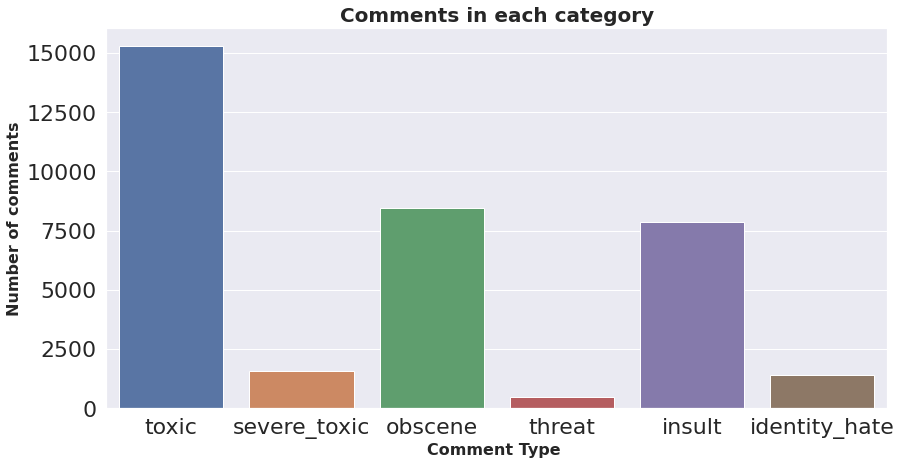

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale = 2)
plt.figure(figsize=(14, 7))

ax= sns.barplot(x=categories, y=comments.iloc[:,2:].sum().values)

plt.title("Comments in each category", fontsize=20, fontweight='bold')
plt.ylabel('Number of comments', fontsize=16, fontweight='bold')
plt.xlabel('Comment Type ', fontsize=16, fontweight='bold')

plt.show() 

Calculating number of comments having multiple labels.

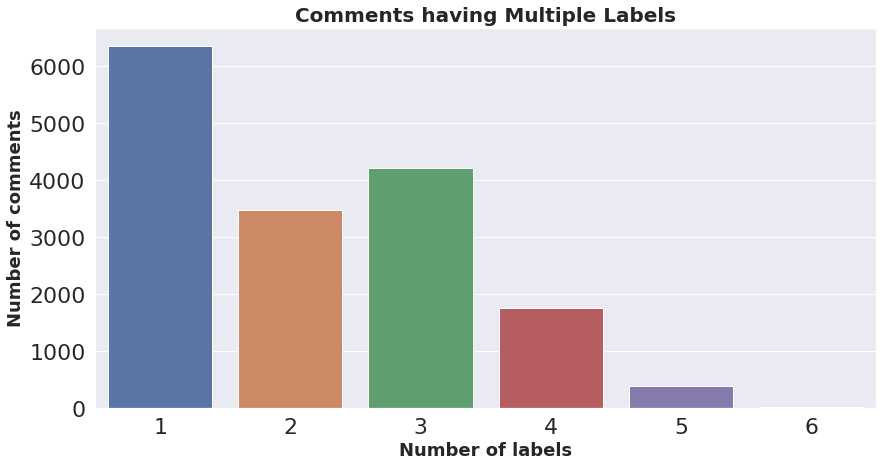

In [13]:
row_sum = comments.iloc[:,2:].sum(axis=1)
multi_label_counts = row_sum.value_counts()
multi_label_counts = multi_label_counts.iloc[1:]

sns.set(font_scale = 2)
plt.figure(figsize=(14, 7))

ax = sns.barplot(x=multi_label_counts.index, y=multi_label_counts.values)

plt.title("Comments having Multiple Labels", fontsize=20, fontweight='bold')
plt.ylabel('Number of comments', fontsize=18, fontweight='bold')
plt.xlabel('Number of labels', fontsize=18, fontweight='bold')  

plt.show() 

Display some comments. Be prepared to see some terrible human behavior... 

In [14]:
import textwrap
import random
#wrap text to 100 characters.
wrapper = textwrap.TextWrapper(width=100)

#filter to just the 'toxic' comments.
toxic_examples = comments['comment_text']

#randomly choose some examples.
for i in range(5):
  j = random.choice(toxic_examples.index)

  print('')
  print(wrapper.fill(toxic_examples[j]))
  print('') 


all art is expressionist.  all art projects a subjective view of the world, at the very least as the
artist necessarily experiences the world subjectively  the article should be changed therefore )


Help? Canvassing for no good reason is more like it. Besides, looks like DreamGuy got chased off
anyways. Good thing, too, 'cuz he was being a pain to some people. You're also up to no good, so I'm
gonna keep an eye on you. -Signed by


Hi Tim.  The latest press release is from PR Newswire.  You can find it here:
http://en.wikipedia.org/wiki/Influenza_A_virus_subtype_H1N1#2009__A.28H1N1.29_pandemic


Because it is negative content about his wife, who is covered and protected under WP:BLP. She's not
notable, as is attested by the deletion of the article about her.


lets make a separate page to summarize the condition of the Russian economy in the transition
period. and this page should be about the current status.



We will be working with the data and preparing for fine tuning purposes. Assuming that the *train.csv* is already downloaded, unzipped and saved in your data folder.

- First step will be to remove the id column from the data.
- A new dataframe is made and input text is stored in the text column.
- The values of all the categories and coverting it into a list.
- The list is appened as a new column names as labels.

In [15]:
comments.drop(['id'], inplace=True, axis=1) # dropping id column

new_df = pd.DataFrame() # creating a new dataframe
new_df['text'] = comments['comment_text'] # text column contains the comments
new_df['labels'] = comments.iloc[:, 1:].values.tolist() # label column contains the list of values
new_df.head() 

,text,labels
0,Explanation\nWhy the edits made under my usern...,"[0, 0, 0, 0, 0, 0]"
1,D'aww! He matches this background colour I'm s...,"[0, 0, 0, 0, 0, 0]"
2,"Hey man, I'm really not trying to edit war. It...","[0, 0, 0, 0, 0, 0]"
3,"""\nMore\nI can't make any real suggestions on ...","[0, 0, 0, 0, 0, 0]"
4,"You, sir, are my hero. Any chance you remember...","[0, 0, 0, 0, 0, 0]"



###**Preparing the Dataset and Dataloader**
We will start with defining few key variables that will be used later during the training/fine tuning stage. Followed by creation of MultiLabelDataset class - This defines how the text is pre-processed before sending it to the neural network. We will also define the Dataloader that will feed the data in batches to the neural network for suitable training and processing. Dataset and Dataloader are constructs of the PyTorch library for defining and controlling the data pre-processing and its passage to neural network. For further reading into Dataset and Dataloader read the [docs at PyTorch](https://pytorch.org/docs/stable/data.html).

***MultiLabelDataset Dataset Class***

- This class is defined to accept the tokenizer, dataframe and max_length as input and generate tokenized output and tags that is used by the BERT model for training.
- We are using the DistilBERT tokenizer to tokenize the data in the text column of the dataframe.
- The tokenizer uses the encode_plus method to perform tokenization and generate the necessary outputs, namely: ids, attention_mask, token_type_ids

- To read further into the tokenizer, [refer to this document](https://huggingface.co/transformers/model_doc/distilbert.html#distilberttokenizer).

- targets is the list of categories labled as 0 or 1 in the dataframe.
- The MultiLabelDataset class is used to create 2 datasets, for training and for validation.
- Training Dataset is used to fine tune the model: 80% of the original data
- Validation Dataset is used to evaluate the performance of the model. The model has not seen this data during training.

***Dataloader***

- Dataloader is used to for creating training and validation dataloader that load data to the neural network in a defined manner. This is needed because all the data from the dataset cannot be loaded to the memory at once, hence the amount of dataloaded to the memory and then passed to the neural network needs to be controlled.
- This control is achieved using the parameters such as `batch_size` and `max_len`.
- Training and Validation dataloaders are used in the training and validation part of the flow respectively.

In [16]:
# Sections of config
from transformers import DistilBertTokenizer
# Defining some key variables that will be used later on in the training.
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True) 

In [17]:
class MultiLabelDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.labels
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        } 

In [18]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8
train_data = new_df.sample(frac=train_size, random_state=2020)
test_data = new_df.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)


print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = MultiLabelDataset(train_data, tokenizer, MAX_LEN)
testing_set = MultiLabelDataset(test_data, tokenizer, MAX_LEN) 

FULL Dataset: (159571, 2)
TRAIN Dataset: (127657, 2)
TEST Dataset: (31914, 2)


In [19]:
# training and testing params

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params) 


###**Creating the Neural Network for Fine Tuning**

***Neural Network***

- We will be creating a neural network with the `DistilBERTClass`.
- This network will have the `DistilBERT model`. Follwed by a Droput and Linear Layer. They are added for the purpose of **Regulariaztion and Classification** respectively.
- In the forward loop, there are 2 output from the` DistilBERTClass` layer.
- The second output output_1 or called the pooled output is passed to the Drop Out layer and the subsequent output is given to the Linear layer.
- Keep note the number of dimensions for Linear Layer is **6** because that is the total number of categories in which we are looking to classify our model.
- The data will be fed to the DistilBERTClass as defined in the dataset.
- Final layer outputs is what will be used to calcuate the loss and to determine the accuracy of models prediction.
- We will initiate an instance of the network called model. This instance will be used for training and then to save the final trained model for future inference.

***Loss Function and Optimizer***
- The Loss is defined in the next cell as `loss_fn`.
- As defined above, the loss function used will be a combination of Binary Cross Entropy which is implemented as [BCELogits Loss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss) in PyTorch.
- `Optimizer` is defined in the next cell.
- `Optimizer` is used to update the weights of the neural network to improve its performance.

In [20]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class DistilBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, 6)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

model = DistilBERTClass()
model.to(device) 

DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_featu

In [21]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets) 

In [22]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE) 


###**Fine Tuning the Model**
After all the effort of loading and preparing the data and datasets, creating the model and defining its loss and optimizer. This is probably the easier steps in the process.

Here we define a training function that trains the model on the training dataset created above, specified number of times (EPOCH), An epoch defines how many times the complete data will be passed through the network.

Following events happen in this function to fine tune the neural network:

- The dataloader passes data to the model based on the batch size.
- Subsequent output from the model and the actual category are compared to calculate the loss.
- Loss value is used to optimize the weights of the neurons in the network.
- After every 5000 steps the loss value is printed in the console.

As you can see just in 1 epoch by the final step the model was working with a miniscule loss of 0.05 i.e. the network output is extremely close to the actual output. 

In [23]:
def train(epoch):
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 

In [24]:
for epoch in range(EPOCHS):
    train(epoch)

1it [00:00,  3.81it/s]

Epoch: 0, Loss:  0.6711362600326538


5003it [05:40, 14.63it/s]

Epoch: 0, Loss:  0.004675615578889847


10003it [11:22, 14.65it/s]

Epoch: 0, Loss:  0.0017543807625770569


15003it [17:04, 14.62it/s]

Epoch: 0, Loss:  0.06801305711269379


20003it [22:45, 14.61it/s]

Epoch: 0, Loss:  0.0005192450480535626


25003it [28:27, 14.64it/s]

Epoch: 0, Loss:  0.0004935408942401409


30003it [34:08, 14.63it/s]

Epoch: 0, Loss:  0.03691963478922844


31915it [36:19, 14.64it/s]


###**Validating the Model**
During the validation stage we pass the unseen data(Testing Dataset) to the model. This step determines how good the model performs on the unseen data.

This unseen data is the 20% of `train.csv` which was seperated during the Dataset creation stage. During the validation stage the weights of the model are not updated. Only the final output is compared to the actual value. This comparison is then used to calcuate the accuracy of the model.

As defined above to get a measure of our models performance we are using the following metrics.

- Hamming Score
- Hamming Loss 

In [25]:
def validation(testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets 

In [26]:
outputs, targets = validation(testing_loader)

final_outputs = np.array(outputs) >=0.5 

7979it [02:44, 48.60it/s]


In [27]:
val_hamming_loss = metrics.hamming_loss(targets, final_outputs)
val_hamming_score = hamming_score(np.array(targets), np.array(final_outputs))

print(f"Hamming Score = {val_hamming_score}")
print(f"Hamming Loss = {val_hamming_loss}") 

Hamming Score = 0.9455944099768125
Hamming Loss = 0.01706670008982474


###**Saving the Trained Model for inference**
This is the final step in the process of fine tuning the model.

The model and its vocabulary are saved locally. 

These files are then used in the future to make inference on new inputs of news headlines.

In [28]:
# Saving the files for inference

output_model_file = '/content/pytorch_distilbert_news.bin'
output_vocab_file = '/content/vocab_distilbert_news.bin'

torch.save(model, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('Saved') 

Saved
